In [ ]:
#@title Import data from GitHub (mlp_class) { display-mode: "form" }
#@markdown Install GpyTorch.

#@markdown Files from GitHub:
#@markdown - **qm_coord.npy** (2100, 14, 3)
#@markdown - **qm_elem.txt** ([8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1])
#@markdown - PM3
#@markdown  - **energy_sqm.npy** (2100,)
#@markdown  - **qm_grad_sqm.npy** (2100, 14, 3)

#@markdown - B3LYP/6-31+G*
#@markdown  - **energy.npy**  (2100,)
#@markdown  - **qm_grad.npy** (2100, 14, 3)

%%capture
!rm *py*
!rm qm_elem.txt
!rm -r sample_data
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/energy.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/energy_sqm.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_grad.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_coord.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_elem.txt

!pip install pytorch-lightning > /dev/null
!pip install gpytorch > /dev/null
!pip install botorch > /dev/null

In [ ]:
#@title Import libraries 

#@markdown - math, numpy

#@markdown - Torch (nn, Tensor)

#@markdown - gpytorch

import math
import numpy as np

import torch
import torch.nn as nn
from torch import Tensor
import gpytorch
from linear_operator.operators import KroneckerProductLinearOperator
from gpytorch.kernels.rbf_kernel import RBFKernel, postprocess_rbf

In [ ]:
tensor_dtype = torch.float32
torch.set_default_dtype(tensor_dtype)


qm_coord = torch.from_numpy(np.array(np.load("qm_coord.npy"), dtype="float32")) 
atom_types = np.loadtxt("qm_elem.txt", dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types])) 
atom_types = atom_types.repeat(len(qm_coord), 1)

energy = torch.from_numpy(np.array((np.load("energy.npy") - np.load("energy_sqm.npy")) * 27.2114 * 23.061, dtype="float32")) 
energy = energy - energy.mean()
qm_gradient = torch.from_numpy(np.array((np.load("qm_grad.npy") - np.load("qm_grad_sqm.npy")) * 27.2114 * 23.061 / 0.529177249, dtype="float32"))

qm_coord, energy, qm_gradient =  qm_coord.to(tensor_dtype), energy.to(tensor_dtype), qm_gradient.to(tensor_dtype)

if torch.cuda.is_available():
    qm_coord, energy, qm_gradient =  qm_coord.cuda(), energy.cuda(), qm_gradient.cuda()
    print('using gpu')

using gpu


In [ ]:
def pairwise_vector(coords: Tensor) -> Tensor:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    return rij

def symmetry_function_g2(rij: Tensor, Rcr: float, EtaR: Tensor, ShfR: Tensor) -> Tensor:
    dij = torch.norm(rij, dim=3)
    fij = torch.where(dij < Rcr, (torch.cos(dij / Rcr * math.pi) + 1) * 0.5, torch.zeros_like(dij))
    g2 = torch.sum(torch.exp(-EtaR * (dij.unsqueeze(dim=-1) - ShfR)**2) * fij.unsqueeze(dim=-1), dim=2)
    return g2/torch.norm(g2, dim=-1, keepdim=True)

def symmetry_function_g3ani(rij: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    f12 = torch.where(d12 < Rca,(torch.cos(d12 / Rca * math.pi) + 1) * 0.5, torch.zeros_like(d12))
    f13 = torch.where(d13 < Rca,(torch.cos(d13 / Rca * math.pi) + 1) * 0.5, torch.zeros_like(d13))
    cosine = torch.sum(r12 * r13, dim=-1) / (d12 * d13)
    cosine =torch.cos(torch.acos(cosine).unsqueeze(-1) - ShfA.unsqueeze(0).unsqueeze(0).unsqueeze(0))#.unsqueeze(2))
    ShfZ = ShfZ.unsqueeze(0).unsqueeze(0).unsqueeze(0)
    g3 = torch.sum(
             2**(1 - Zeta) * (1 + cosine)**Zeta * torch.exp(-EtaA * (0.5 * (d12 + d13).unsqueeze(-1) - ShfZ)**2) * (f12 * f13).unsqueeze(-1), dim=2
    )
    return g3/torch.norm(g3, dim=-1, keepdim=True)


In [ ]:
class FeatureANI(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> None:
        super().__init__()
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = EtaR 
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.ShfZ = torch.Tensor(ShfZ)
        self.EtaA = EtaA 
        self.ShfA = torch.Tensor(ShfA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR
        EtaA = self.EtaA
        ShfR = self.ShfR.to(device=coords.device)
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)

        Zeta = self.Zeta.to(device=coords.device)
        ShfZ = self.ShfZ.to(device=coords.device)
        ShfA = self.ShfA.to(device=coords.device)
        #g3 = symmetry_function_g3ani(rij, self.Rca, Zeta, ShfZ, EtaA, ShfA)
        #g2g3 = torch.concat((g2, g3), dim=2)
        return g2.reshape(g2.shape[0], -1) #g2g3.reshape(g2g3.shape[0], -1) 

In [ ]:
# From TorchANI
Rcr = 5.2000e+00
Rca = 3.5000e+00
EtaR = 1.6000000e+01
ShfR = [9.0000000e-01,1.1687500e+00,1.4375000e+00,1.7062500e+00,1.9750000e+00,2.2437500e+00,2.5125000e+00,2.7812500e+00,3.0500000e+00,3.3187500e+00,3.5875000e+00,3.8562500e+00,4.1250000e+00,4.3937500e+00,4.6625000e+00,4.9312500e+00]
Zeta = [3.2000000e+01]
ShfZ = [1.9634954e-01,5.8904862e-01,9.8174770e-01,1.3744468e+00,1.7671459e+00,2.1598449e+00,2.5525440e+00,2.9452431e+00]
EtaA = 8.0000000e+00
ShfA = [9.0000000e-01,1.5500000e+00,2.2000000e+00,2.8500000e+00]
ShfZ, ShfA = np.array(np.meshgrid(ShfZ, ShfA, indexing='ij')).reshape(2,-1)

descriptor = FeatureANI(Rcr, EtaR, ShfR, Rca, Zeta, ShfZ, EtaA, ShfA)

In [ ]:
nskip = 30 
nsamp = 2100

# Prepare Training Data
X = qm_coord[:nsamp:nskip,:,:]
descriptor(X,atom_types.repeat(X.shape[0], 1))
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
e = energy[:nsamp:nskip]
e = e.reshape(e.shape[0],1)
g = qm_gradient[:nsamp:nskip,:,:]
g = g.reshape(g.shape[0], g.shape[1]*g.shape[2])
Y = torch.concat((e,g), axis=1)


In [ ]:
def get_x(crd,crd_transform):
    x = crd_transform(crd, atom_types.repeat(crd.shape[0],1)).sum(dim=0)
    return x

def get_jac(crd):
  jac = torch.autograd.functional.jacobian(lambda x: get_x(x, descriptor), crd, create_graph=False)
  return jac

ntrain = int(nsamp/nskip)
trace = get_jac(X.reshape(ntrain,14,3))
traced_jac = torch.jit.trace(get_jac,example_inputs=(X.reshape(ntrain,14,3)))


In [ ]:
class RBFKernelGrad_IC(gpytorch.kernels.rbf_kernel_grad.RBFKernelGrad):
  def forward(self, crd1, crd2, crd_transform, atom_types, grad1, grad2=None, last_dim_is_batch=False, diag=False):
    crd1 = crd1.reshape(crd1.shape[0], int(crd1.shape[1]/3), 3)
    crd2 = crd2.reshape(crd2.shape[0], int(crd2.shape[1]/3), 3)
    nc1, natm1, ncc1 = crd1.shape
    nc2, natm2, ncc2 = crd2.shape
    da = natm1*ncc1
    atom_types1 = atom_types.repeat(nc1, 1)
    atom_types2 = atom_types.repeat(nc2, 1)
    x1 = crd_transform(crd1, atom_types1)
    x2 = crd_transform(crd2,atom_types2)
    nconfig1, d = x1.shape #d1 = 600
    nconfig2, d2 = x2.shape #d2 = 600
    if grad2 is None:
        grad2 = grad1 
    d_grad, d_nconfig, natm, ncc = grad1.shape # 600, nc1, 14, 3

    K = torch.zeros(nc1 * (natm*ncc + 1), nc2 * (natm*ncc + 1), device=X.device, dtype=X.dtype)

    # Scale the inputs by the lengthscale (for stability)
    x1_ = x1.div(self.lengthscale)
    x2_ = x2.div(self.lengthscale)

    # Form all possible rank-1 products for the gradient and Hessian blocks
    outer = x1_.view(nconfig1, 1, d) - x2_.view(1, nconfig2, d)
    outer = outer.div(self.lengthscale.unsqueeze(-2)) #outer / self.lengthscale.unsqueeze(-2)
    outer = torch.transpose(outer, -1, -2).contiguous()

    # 1) Kernel block
    diff = self.covar_dist(x1_, x2_, square_dist=True)
    K00 = postprocess_rbf(diff)
    K[..., :nconfig1, :nconfig2] = K00

    # 2) First gradient block
    outer1 = torch.einsum("ijk,jklm->iklm", outer, grad2).permute(0,2,3,1).reshape(nconfig1, nconfig2 * natm * ncc)
    K[..., :nconfig1, nconfig2:] = outer1 * K00.repeat([*([1] * (1)), natm*ncc])
 
    # 3) Second gradient block
    outer2 = torch.einsum("ijk,jilm-> iklm", outer, grad1).permute(2,3,0,1).reshape(nconfig1*natm*ncc, nconfig2)
    K[..., nconfig1:, :nconfig2] = -outer2 * K00.repeat([*([1]), natm*ncc, 1])

    # 4) Hessian block
    outer1_x = outer.view(nconfig1, nconfig2 * d)
    outer2_x = outer.transpose(-1, -3).reshape(nconfig2, nconfig1 * d)
    outer2_x = outer2_x.transpose(-1, -2)
    kp = KroneckerProductLinearOperator(
                torch.eye(d, d, device=x1.device, dtype=x1.dtype)/ self.lengthscale.pow(2),
                torch.ones(nconfig1, nconfig2, device=x1.device, dtype=x1.dtype),
            )
    outer3_x = outer1_x.repeat([*([1]), d, 1]) * outer2_x.repeat([*([1] * (1)), d])
    chain_rule = kp - outer3_x
    d2Kdx1dx2 = chain_rule * (K00.repeat([*([1]), d, d]))
    d2Kdx1dx2 = d2Kdx1dx2.to_dense().reshape(d, nconfig1, d, nconfig2)
    grad1_in = grad1.reshape(grad1.shape[0], grad1.shape[1], grad1.shape[2]*grad1.shape[3])
    grad2_in = grad2.reshape(grad2.shape[0], grad2.shape[1], grad2.shape[2]*grad2.shape[3])

    # use einsum to perform tensor contractions
    d2Kdcc1dx2 = torch.einsum('ijkl,ijm->jklm', d2Kdx1dx2, grad1_in)
    d2Kdcc1dcc2 = torch.einsum('ijkl,jkm->iklm', d2Kdcc1dx2, grad2_in)
    K[..., nconfig1:, nconfig2:] = d2Kdcc1dcc2.permute(2, 0, 3, 1).reshape(nconfig1*natm*ncc, nconfig2*natm*ncc)

    # Symmetrize for stability
    if nc1 == nc2 and torch.eq(x1, x2).all():
      K = 0.5 * (K.transpose(-1, -2) + K)

    # Apply a perfect shuffle permutation to match the MutiTask ordering
    pi1 = torch.arange(nconfig1 * (natm*ncc + 1)).view(natm*ncc + 1, nconfig1).t().reshape((nconfig1 * (natm*ncc + 1)))
    pi2 = torch.arange(nconfig2 * (natm*ncc + 1)).view(natm*ncc + 1, nconfig2).t().reshape((nconfig2 * (natm*ncc + 1)))
    K = K[..., pi1, :][..., :, pi2]

    return K

class BPGPRwDO_Man(gpytorch.models.ExactGP):
    def __init__(self, crd: Tensor, Y: Tensor, likelihood, crd_transform, atom_types, grad_calc) -> None:
        super(BPGPRwDO_Man, self).__init__(crd, Y, likelihood)
        self.crd_transform = crd_transform
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = RBFKernelGrad_IC(lengthscale_constraint=gpytorch.constraints.GreaterThan(1e-4))
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)
        self.atom_types = atom_types
        crd = crd.reshape(crd.shape[0], int(crd.shape[1]/3), 3)
        self.X = self.crd_transform(crd, self.atom_types.repeat(crd.shape[0],1))
        self.grad_calc = grad_calc
        self.grad = self.grad_calc(crd)
        self.crd = crd

    def forward(self, crd):
        mean_x = self.mean_module(crd)
        if self.training: 
            X1 = crd
            X2 = torch.clone(crd)
            grad = self.grad
            covar_x = self.covar_module(X1,X2,crd_transform = self.crd_transform, atom_types = self.atom_types, grad1=grad)
        else: 
            crd1 = crd.reshape(crd.shape[0], int(crd.shape[1]/3), 3)
            grad = get_jac(crd1)
            covar_x = self.covar_module(crd, torch.clone(crd), crd_transform = self.crd_transform, atom_types = self.atom_types, grad1=grad)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)


In [ ]:
likelihood1 = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(14*3+1),has_global_noise=True,has_task_noise=False)
model1 = BPGPRwDO_Man(X, Y, likelihood1, descriptor, atom_types, traced_jac)

if torch.cuda.is_available():
    model1 = model1.cuda()
    likelihood1 = likelihood1.cuda()

In [ ]:
# Use local optimizer to train model 
model1.train()
likelihood1.train()

if torch.cuda.is_available():
    model1 = model1.cuda()
    likelihood1 = likelihood1.cuda()

model1.covar_module.outputscale = 1.0
model1.covar_module.base_kernel.lengthscale = 1.0
model1.likelihood.noise = 1.0

training_iter = 25 
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1)
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model1(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model1.covar_module.base_kernel.lengthscale.item(),
        model1.likelihood.noise.item()
    ))
    optimizer.step()

# Print Trained hyperparameters
print('mean: ', model1.mean_module.constant)
print('outputscale: ', model1.covar_module.outputscale.item())
print('lengthscale: ', model1.covar_module.base_kernel.lengthscale.item())
print('noise: ', model1.likelihood.noise.item())

torch.cuda.empty_cache()

Iter 1/25 - Loss: 6.061   lengthscale: 1.000   noise: 1.000
Iter 2/25 - Loss: 6.000   lengthscale: 0.994   noise: 1.006
Iter 3/25 - Loss: 5.934   lengthscale: 0.987   noise: 1.013
Iter 4/25 - Loss: 5.860   lengthscale: 0.981   noise: 1.019
Iter 5/25 - Loss: 5.791   lengthscale: 0.975   noise: 1.025
Iter 6/25 - Loss: 5.728   lengthscale: 0.969   noise: 1.032
Iter 7/25 - Loss: 5.662   lengthscale: 0.963   noise: 1.038
Iter 8/25 - Loss: 5.597   lengthscale: 0.956   noise: 1.045
Iter 9/25 - Loss: 5.545   lengthscale: 0.950   noise: 1.051
Iter 10/25 - Loss: 5.487   lengthscale: 0.944   noise: 1.057
Iter 11/25 - Loss: 5.425   lengthscale: 0.938   noise: 1.064
Iter 12/25 - Loss: 5.366   lengthscale: 0.932   noise: 1.070
Iter 13/25 - Loss: 5.308   lengthscale: 0.926   noise: 1.076
Iter 14/25 - Loss: 5.252   lengthscale: 0.920   noise: 1.083
Iter 15/25 - Loss: 5.190   lengthscale: 0.915   noise: 1.089
Iter 16/25 - Loss: 5.151   lengthscale: 0.909   noise: 1.095
Iter 17/25 - Loss: 5.086   length

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Use basinhopping algorithm to optimize hyper parameters
import scipy
from scipy.optimize import basinhopping

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood1, model1)
model1.train()
likelihood1.train()

def torch_wrapper(x):
    x = torch.tensor(x, requires_grad=True)

    model1.likelihood.noise = x[0]
    model1.mean_module.constant = torch.nn.Parameter(Tensor([x[1]]).cuda(), requires_grad=True)
    model1.covar_module.base_kernel.lengthscale = x[2]
    model1.covar_module.outputscale = x[3]

    output = model1(X) 
    loss = -mll(output,Y)
    grads = []
    loss.backward()
    for param in model1.parameters():
        grads.append(param.grad.cpu().item())

    return loss.item(), np.array(grads)

class Global_Bounds:
    def __init__(self, xmax=[10.0,10.0,1000.0,1000.0], xmin=[0.01,-10.0,0.01,0.01] ):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)

    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        return tmax and tmin

x0_0 = model1.likelihood.noise.item()
x0_1 = model1.mean_module.constant.item()
x0_2 = model1.covar_module.base_kernel.lengthscale.item()
x0_3 = model1.covar_module.outputscale.item()

x0 = np.array([x0_0, x0_1, x0_2, x0_3])

global_bounds = Global_Bounds()
local_bounds=((0.01,10.0), (-10.0,10.0),(0.01,1000.0),(0.01,1000.0))

res = basinhopping(torch_wrapper, x0, disp=True,
                                  minimizer_kwargs=dict(method="L-BFGS-B", bounds=local_bounds, options={'disp': None, 'maxls': 40}, jac=True),
                                  accept_test=global_bounds,
                                  niter_success = 40
                                  )

print(res)

torch.cuda.empty_cache()


basinhopping step 0: f 3.51266
basinhopping step 1: f 3.51266 trial_f 3.69118 accepted 0  lowest_f 3.51266
basinhopping step 2: f 3.76152 trial_f 3.76152 accepted 1  lowest_f 3.51266
basinhopping step 3: f 3.64038 trial_f 3.64038 accepted 1  lowest_f 3.51266
basinhopping step 4: f 3.3215 trial_f 3.3215 accepted 1  lowest_f 3.3215
found new global minimum on step 4 with function value 3.3215
basinhopping step 5: f 3.073 trial_f 3.073 accepted 1  lowest_f 3.073
found new global minimum on step 5 with function value 3.073
basinhopping step 6: f 3.04932 trial_f 3.04932 accepted 1  lowest_f 3.04932
found new global minimum on step 6 with function value 3.04932
basinhopping step 7: f 3.06145 trial_f 3.06145 accepted 1  lowest_f 3.04932
basinhopping step 8: f 3.02073 trial_f 3.02073 accepted 1  lowest_f 3.02073
found new global minimum on step 8 with function value 3.02073
basinhopping step 9: f 3.02073 trial_f 3.56889 accepted 0  lowest_f 3.02073
basinhopping step 10: f 3.02073 trial_f 3.386

In [ ]:
# Make Predictions 
model1.eval()
likelihood1.eval()

print(X.shape)
nsamp = 2100
ii = 100
jj = int(nsamp/ii)
print(jj)
for i in range(ii):
    qm_crd = qm_coord[i*jj:(i+1)*jj,:,:].reshape(jj,14*3) 
    with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
        y_preds = model1(qm_crd.cuda())
    if i == 0:
      y_mean = y_preds.mean.detach()
      #y_var = y_preds.var
      print('i: ', i)
    else:
      y_mean = torch.concat((y_mean, y_preds.mean.detach()), axis=0)   
      #y_var = torch.concat((y_var, y_preds.var), axis=0)
      print('i: ', i)
    del y_preds
    torch.cuda.empty_cache()

torch.Size([70, 42])
21
torch.Size([21, 42])
i:  0
torch.Size([21, 42])
i:  1
torch.Size([21, 42])
i:  2
torch.Size([21, 42])
i:  3
torch.Size([21, 42])
i:  4
torch.Size([21, 42])
i:  5
torch.Size([21, 42])
i:  6
torch.Size([21, 42])
i:  7
torch.Size([21, 42])
i:  8
torch.Size([21, 42])
i:  9
torch.Size([21, 42])
i:  10
torch.Size([21, 42])
i:  11
torch.Size([21, 42])
i:  12
torch.Size([21, 42])
i:  13
torch.Size([21, 42])
i:  14
torch.Size([21, 42])
i:  15
torch.Size([21, 42])
i:  16
torch.Size([21, 42])
i:  17
torch.Size([21, 42])
i:  18
torch.Size([21, 42])
i:  19
torch.Size([21, 42])
i:  20
torch.Size([21, 42])
i:  21
torch.Size([21, 42])
i:  22
torch.Size([21, 42])
i:  23
torch.Size([21, 42])
i:  24
torch.Size([21, 42])
i:  25
torch.Size([21, 42])
i:  26
torch.Size([21, 42])
i:  27
torch.Size([21, 42])
i:  28
torch.Size([21, 42])
i:  29
torch.Size([21, 42])
i:  30
torch.Size([21, 42])
i:  31
torch.Size([21, 42])
i:  32
torch.Size([21, 42])
i:  33
torch.Size([21, 42])
i:  34
torch.

In [ ]:
# Evaluate Performance 
def eval(ref, pred):
    rmse = torch.sqrt(torch.mean((ref-pred)**2))
    q2 = 1 - torch.sum((ref-pred)**2)/torch.sum((ref-torch.mean(ref))**2)
    return rmse, q2

e_pred = y_mean[:,0]
print(e_pred.shape)
y_rmse, y_q2 = eval(energy[:nsamp].cpu() ,e_pred.cpu())
print("Testing Set Energy Prediction RMSE: ", y_rmse,"Q^2: ", y_q2)

rmse = torch.sqrt(torch.mean((y_mean[:,1:].reshape(nsamp,14,3) - qm_gradient[:nsamp])**2))
q2 = 1 - torch.sum((qm_gradient[:nsamp]-y_mean[:,1:].reshape(nsamp,14,3))**2)/torch.sum((qm_gradient[:nsamp]-torch.mean(qm_gradient[:nsamp]))**2)
print("Testing Set Force RMSE: ", rmse, "Q^2", q2)

e_pred_train = y_mean[::nskip,0]
y_rmse, y_q2 = eval(energy[:nsamp:nskip] ,e_pred_train)
print("Training Set Energy Prediction RMSE: ", y_rmse,"Q^2: ", y_q2)

rmse = torch.sqrt(torch.mean((y_mean[::nskip,1:].reshape(int(nsamp/nskip),14,3) - qm_gradient[:nsamp:nskip,:,:])**2))
q2 = 1 - torch.sum((qm_gradient[:nsamp:nskip,:,:]-y_mean[::nskip,1:].reshape(int(nsamp/nskip),14,3))**2)/torch.sum((qm_gradient[:nsamp:nskip,:,:]-torch.mean(qm_gradient[:nsamp:nskip,:,:]))**2)
print("Training Set Force RMSE: ", rmse, "Q^2", q2)

torch.Size([2100])
Testing Set Energy Prediction RMSE:  tensor(1.7916) Q^2:  tensor(0.7700)
Testing Set Force RMSE:  tensor(3.9402, device='cuda:0') Q^2 tensor(0.8214, device='cuda:0')
Training Set Energy Prediction RMSE:  tensor(1.4835, device='cuda:0') Q^2:  tensor(0.7738, device='cuda:0')
Training Set Force RMSE:  tensor(1.2628, device='cuda:0') Q^2 tensor(0.9815, device='cuda:0')


In [ ]:
print("PM3 Errors")
y_rmse, y_q2 = eval(energy[:nsamp].cpu() ,e_pred.cpu())
rmse = torch.sqrt(torch.mean(energy**2))
print("Testing Set Energy RMSE: ", rmse)

rmse = torch.sqrt(torch.mean((qm_gradient[:nsamp])**2))
print("Testing Set Force RMSE: ", rmse)

rmse = torch.sqrt(torch.mean(energy[:nsamp:nskip]**2))
print("Training Set Energy RMSE: ", rmse)

rmse = torch.sqrt(torch.mean((qm_gradient[:nsamp:nskip])**2))
print("Training Set Force RMSE: ", rmse)

PM3 Errors
Testing Set Energy RMSE:  tensor(3.7353, device='cuda:0')
Testing Set Force RMSE:  tensor(9.3227, device='cuda:0')
Training Set Energy RMSE:  tensor(3.1239, device='cuda:0')
Training Set Force RMSE:  tensor(9.2821, device='cuda:0')


In [ ]:
rmse = torch.sqrt(torch.mean((y_mean[:,1:].reshape(nsamp,14,3)[::nskip,:6,:] - qm_gradient[:nsamp:nskip,:6,:])**2))
print("Training set force RMSE on heavy atoms: ", rmse)
rmse = torch.sqrt(torch.mean((y_mean[:,1:].reshape(nsamp,14,3)[:,:6,:] - qm_gradient[:nsamp,:6,:])**2))
print("Testing set force RMSE on heavy atoms: ", rmse)
rmse = torch.sqrt(torch.mean((qm_gradient[:nsamp:nskip,:6])**2))
print("PM3 Training Set Force RMSE on heavy atoms: ", rmse)
rmse = torch.sqrt(torch.mean((qm_gradient[:nsamp,:6])**2))
print("PM3 Testing Set Force RMSE on heavy atoms: ", rmse)

Training set force RMSE on heavy atoms:  tensor(1.5713, device='cuda:0')
Testing set force RMSE on heavy atoms:  tensor(5.1867, device='cuda:0')
PM3 Training Set Force RMSE on heavy atoms:  tensor(13.0986, device='cuda:0')
PM3 Testing Set Force RMSE on heavy atoms:  tensor(13.1457, device='cuda:0')


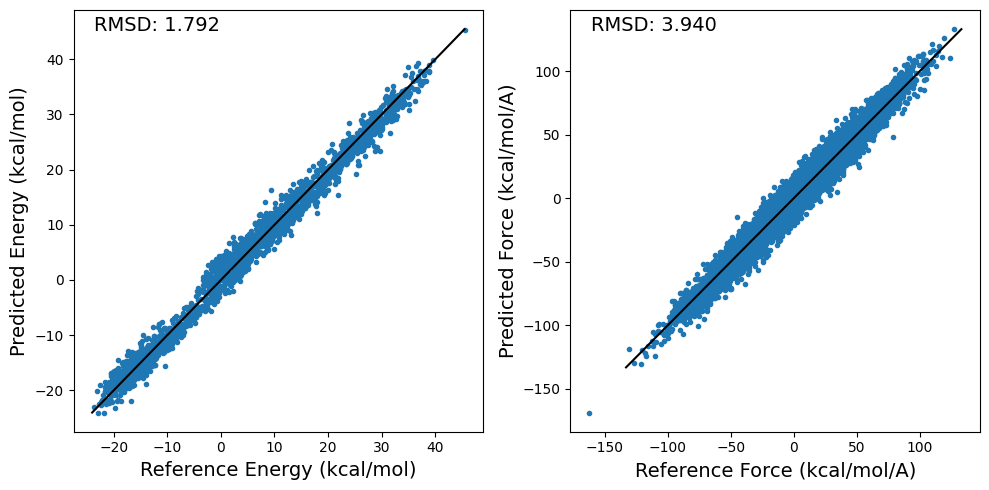

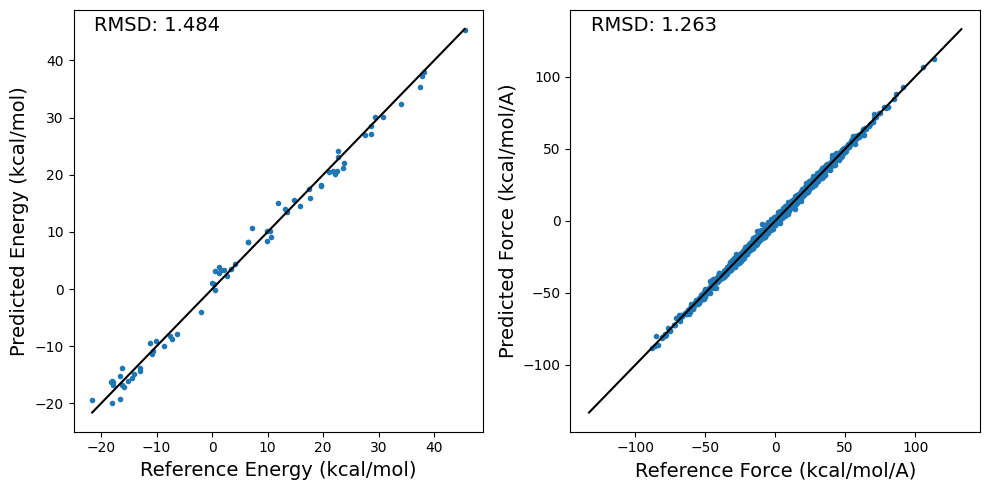

In [ ]:
# Plot Performance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,5))

e1 = energy[:nsamp].detach().cpu().numpy().flatten() + np.load("energy_sqm.npy") * 27.2114 * 23.061
e2 = e_pred.detach().cpu().numpy().flatten() + np.load("energy_sqm.npy") * 27.2114 * 23.061
ax[0].plot(e1, e2, linestyle='none', marker='.', )
ax[0].plot([np.max(np.concatenate((e1,e2))), np.min(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), np.min(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient[:nsamp].detach().cpu().numpy().reshape(-1) - np.load("qm_grad_sqm.npy").reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -y_mean[:,1:].detach().cpu().numpy().reshape(-1) - np.load("qm_grad_sqm.npy").reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.', )
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel("Reference Force (kcal/mol/A)", size=14)
ax[1].set_ylabel("Predicted Force (kcal/mol/A)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()

fig, ax = plt.subplots(1,2,figsize=(10,5))

e1_train = e1[::nskip]
e2_train = e2[::nskip]
ax[0].plot(e1_train, e2_train, linestyle='none', marker='.', )
ax[0].plot([np.max(np.concatenate((e1_train,e2_train))), np.min(np.concatenate((e1_train,e2_train)))], [np.max(np.concatenate((e1_train,e2_train))), np.min(np.concatenate((e1_train,e2_train)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1_train - e2_train)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1_ = -qm_gradient.detach().cpu().numpy() - np.load("qm_grad_sqm.npy") * 27.2114 * 23.061 / 0.529177249
f2_ = -y_mean[:,1:].detach().cpu().numpy() - np.load("qm_grad_sqm.npy").reshape(2100,-1) * 27.2114 * 23.061 / 0.529177249
f1_train = f1_[:nsamp:nskip,:,:].reshape(-1)
f2_train = f2_[::nskip,:].reshape(-1)

ax[1].plot(f1_train, f2_train, linestyle='none', marker='.', )
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel("Reference Force (kcal/mol/A)", size=14)
ax[1].set_ylabel("Predicted Force (kcal/mol/A)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1_train - f2_train)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()

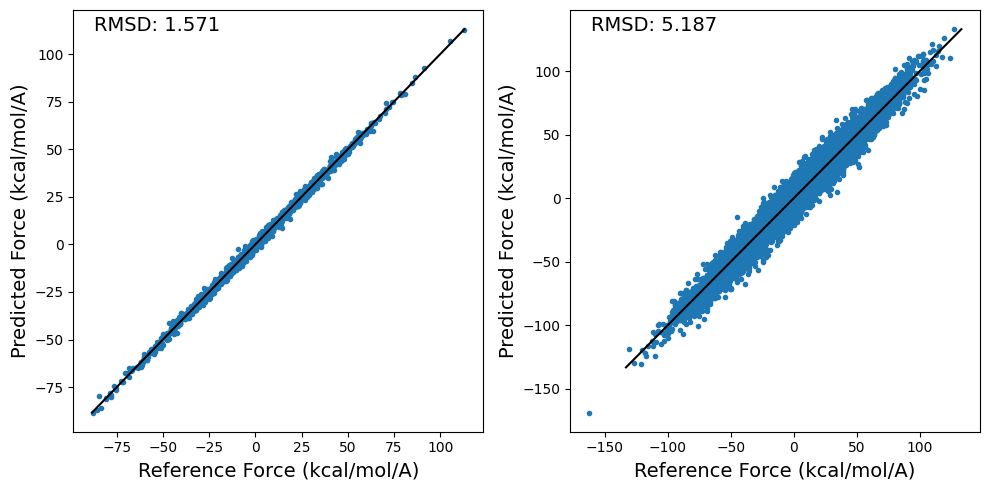

In [ ]:
# Plot Performance on Heavy Atoms
fig, ax = plt.subplots(1,2,figsize=(10,5))

f1 = -qm_gradient[:nsamp,:6,:].detach().cpu().numpy() - np.load("qm_grad_sqm.npy")[:nsamp,:6,:] * 27.2114 * 23.061 / 0.529177249
f2 = -y_mean[:,1:].reshape(nsamp,14,3)[:,:6,:].detach().cpu().numpy() - np.load("qm_grad_sqm.npy")[:nsamp,:6,:] * 27.2114 * 23.061 / 0.529177249
f1_train = f1[::nskip].reshape(-1)
f2_train = f2[::nskip].reshape(-1)
f1 = f1.reshape(-1)
f2 = f2.reshape(-1)

ax[0].plot(f1_train, f2_train, linestyle='none', marker='.', )
ax[0].plot([np.max(np.concatenate((f1_train,e2))), np.min(np.concatenate((f1_train,f2_train)))], [np.max(np.concatenate((f1_train,f2_train))), np.min(np.concatenate((f1_train,f2_train)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Force (kcal/mol/A)", size=14)
ax[0].set_ylabel("Predicted Force (kcal/mol/A)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1_train - f2_train)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

ax[1].plot(f1, f2, linestyle='none', marker='.', )
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel("Reference Force (kcal/mol/A)", size=14)
ax[1].set_ylabel("Predicted Force (kcal/mol/A)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()

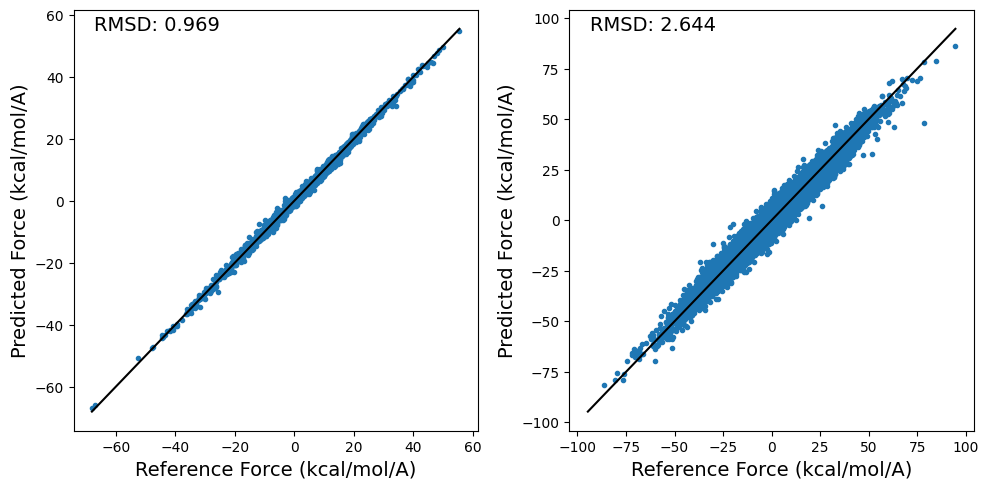

In [ ]:
# Plot Performance on Light Atoms
fig, ax = plt.subplots(1,2,figsize=(10,5))

f1 = -qm_gradient[:nsamp,6:,:].detach().cpu().numpy() - np.load("qm_grad_sqm.npy")[:nsamp,6:,:] * 27.2114 * 23.061 / 0.529177249
f2 = -y_mean[:,1:].reshape(nsamp,14,3)[:,6:,:].detach().cpu().numpy() - np.load("qm_grad_sqm.npy")[:nsamp,6:,:] * 27.2114 * 23.061 / 0.529177249
f1_train = f1[::nskip].reshape(-1)
f2_train = f2[::nskip].reshape(-1)
f1 = f1.reshape(-1)
f2 = f2.reshape(-1)

ax[0].plot(f1_train, f2_train, linestyle='none', marker='.', )
ax[0].plot([np.max(np.concatenate((f1_train,e2))), np.min(np.concatenate((f1_train,f2_train)))], [np.max(np.concatenate((f1_train,f2_train))), np.min(np.concatenate((f1_train,f2_train)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Force (kcal/mol/A)", size=14)
ax[0].set_ylabel("Predicted Force (kcal/mol/A)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1_train - f2_train)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

ax[1].plot(f1, f2, linestyle='none', marker='.', )
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel("Reference Force (kcal/mol/A)", size=14)
ax[1].set_ylabel("Predicted Force (kcal/mol/A)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()